Calculating 1D Fan-Migdal self-enengy sigma(k,E)...
 Calculating for k-point 20/200...
 Calculating for k-point 40/200...
 Calculating for k-point 60/200...
 Calculating for k-point 80/200...
 Calculating for k-point 100/200...
 Calculating for k-point 120/200...
 Calculating for k-point 140/200...
 Calculating for k-point 160/200...
 Calculating for k-point 180/200...
 Calculating for k-point 200/200...
Calculation finished in 7.63 seconds.

Calculating spectral function A(k,E)...
Plotting results...


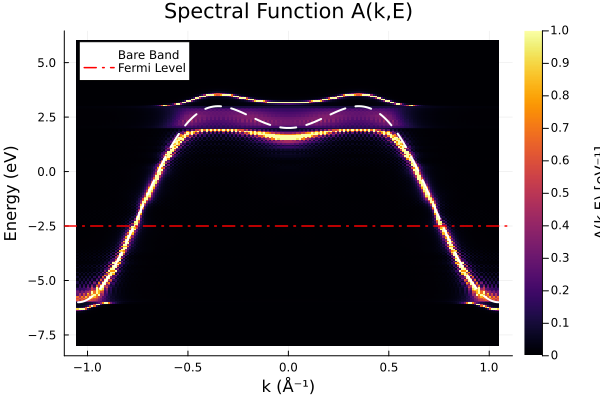

Plot saved to spectral_function_julia.png


In [ ]:
# run_calculation.jl
# 确保在当前目录下有 Spectral.jl 文件
include("Spectral.jl") 
using .Spectral # 使用我们定义的模块
using Plots     # 引入绘图库

# --- 设置参数 ---
tt_paras = Dict(
    "prefix" => "test",
    "a_lattice" => 3.0,
    "efermi" => -2.5, # 注意：python脚本中画图的费米能和计算用的不一致，这里统一为计算值
)add

tt = Spectral1D(tt_paras)

# --- 定义裸能带结构 ---
t_hop = 1.0
epsilon_k_bare(k_val) = -2 * t_hop * cos(k_val * 2 * tt.a_lattice) + 4 * t_hop * cos(k_val * tt.a_lattice)

# --- 定义 k 点和能量网格 ---
min_energy_1D = -8.0
max_energy_1D = 6.0
k_values_1D = range(-0.5 * tt.reci_lattice, 0.5 * tt.reci_lattice, length=200)
energy_values_1D = range(min_energy_1D, max_energy_1D, length=200)

# --- 计算自能矩阵 ---
# 注意：为了利用多线程，请确保启动 Julia 时开启了多线程
# 例如: julia --threads auto run_calculation.jl
sigma_mat = calc_sigma_FM_1D(
    tt,
    epsilon_k_bare,
    k_values_1D,
    energy_values_1D,
    0.5,      # g0_1D_sq_ev2
    0.01,     # hw_phonon_ev
    300.0,    # temp_k
    -2.5,     # efermi_ev
    300,      # num_q_points
    0.01      # h_delta_ev
)

# --- 计算谱函数 A(k,E) ---
println("Calculating spectral function A(k,E)...")
sigma_real = real.(sigma_mat)
sigma_imag = imag.(sigma_mat)

# 利用 Julia 的广播特性进行高效计算，避免写双重循环
# 1. 将 k 和 energy 向量扩展成网格
k_grid = k_values_1D'  # 1x200
e_grid = energy_values_1D   # 200x1

# 2. 计算每个 k 点的裸能量，并扩展成网格
ek_bare_grid = epsilon_k_bare.(k_grid)

# 3. 单行代码计算整个谱函数矩阵
numerator = -sigma_imag ./ π
denominator = (e_grid .- ek_bare_grid .- sigma_real).^2 .+ sigma_imag.^2
A_k_E = numerator ./ denominator

println("Plotting results...")
# --- 绘图 ---
gr() # 激活 GR 后端
plt = heatmap(
    k_values_1D,
    energy_values_1D,
    A_k_E,
    c = :inferno, # 设置颜色映射
    clim = (0, 1), # 设置颜色范围
    xlabel = "k (Å⁻¹)",
    ylabel = "Energy (eV)",
    title = "Spectral Function A(k,E)",
    colorbar_title = "\nA(k,E) [eV⁻¹]" # 使用换行符调整位置
)

# 叠加裸能带曲线
plot!(
    plt,
    k_values_1D,
    epsilon_k_bare.(k_values_1D),
    linestyle = :dash,
    color = :white,
    linewidth = 2,
    label = "Bare Band"
)

# 叠加费米能级线
hline!(
    plt,
    [tt.efermi],
    linestyle = :dashdot,
    color = :red,
    linewidth = 1.5,
    label = "Fermi Level"
)

# 显示和保存图像
display(plt)
savefig(plt, "spectral_function_julia.png")
println("Plot saved to spectral_function_julia.png")